<a href="https://colab.research.google.com/github/wall456/CTG/blob/main/svc_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
raw_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Final_Project_DS1_2020/CTG.csv")
raw_data = raw_data.iloc[:-3]
cleaned_data = raw_data.drop(columns=['LBE', 'SegFile', 'FileName', 'Date', 'DR', 'b', 'e', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS', 'NSP'])
X = cleaned_data
y = raw_data['NSP']
n, d = X.shape


holdout_frac = 0.2
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.loc[model_idx], y.loc[model_idx]
X_h, y_h = X.loc[holdout_idx], y.loc[holdout_idx]

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
pipe = Pipeline([('scale', StandardScaler()),
                 ('dim_reduce', PCA()),
                 ('classify', SVC())
                 ])
hypers = {'dim_reduce__n_components': (1, 19),
          'classify__kernel': ['rbf'],
          'classify__C': (1, 100),
          }
grid = GridSearchCV(pipe, hypers, cv=10, scoring='f1_macro').fit(X_m, y_m)

In [ ]:
res = grid.cv_results_
df = pd.DataFrame(res['params'])
df['score'] = res['mean_test_score']
top = df['score'].max()
mask = df['score'] >= top

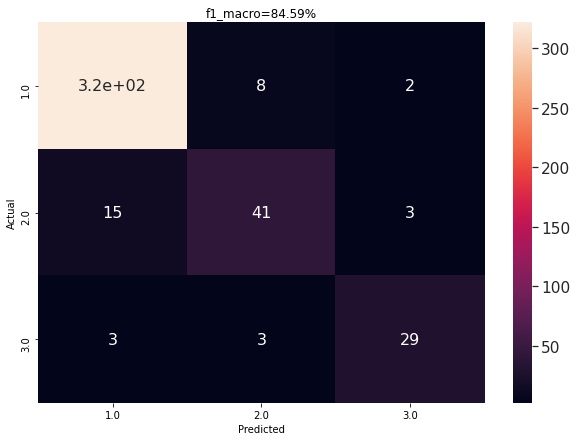

   classify__C classify__kernel  dim_reduce__n_components     score
3          100              rbf                        19  0.876844


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
def display_confusion_matrix(y_true, y_pred):
    """Pretty display for confusion matrix"""
    labels = np.unique(y_true)
    cf = confusion_matrix(y_true, y_pred, labels)
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    df = pd.DataFrame(cf, columns=labels, index=labels)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title(f'f1_macro={f1:.2f}%')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df, annot=True,annot_kws={"size": 16})# font size
    plt.show()


    idx = y_true != y_pred
    df_errors = pd.DataFrame()
    df_errors['y_true'] = y_true[idx]
    df_errors['y_pred'] = y_pred[idx]
    #display(df_errors)
    return df

y_pred = grid.predict(X_h)
display_confusion_matrix(y_h, y_pred)
print(df[mask])